# Backpropagation in Multilayer Perceptron with Numpy

This notebook is based on the Deep Learning course from the Master Datascience Paris Saclay. Materials of the course can be found [here](https://github.com/m2dsupsdlclass/lectures-labs). 

### Goal of the notebook:
   * Implement a real gradient descent and a multilayer perceptron using `Numpy`.
   
### Dataset used:
   * The MNIST dataset ([Kaggle link](https://www.kaggle.com/c/digit-recognizer/overview)).

In [2]:
# Display figure in the notebook
%matplotlib inline

In [3]:
# Load packages
import random

# from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras import initializers, optimizers
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.utils import to_categorical

2024-08-20 20:40:40.993288: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Define some functions
def plot_mnist(data, index, label=None):
    """Plot one image from the mnist dataset."""
    fig = plt.figure(figsize=(3, 3))
    if type(data) == pd.DataFrame:
        plt.imshow(np.asarray(data.iloc[index, 1:]).reshape((HEIGHT, WIDTH)),
                   cmap=plt.cm.gray_r,
                   interpolation='nearest')
        plt.title(f"Image label: {data.loc[index, 'label']}")
    else:
        plt.imshow(data[index].reshape((HEIGHT, WIDTH)),
                   cmap=plt.cm.gray_r,
                   interpolation='nearest')
        plt.title(f"Image label: {label}")
    
    plt.axis('off')
    return fig

def plot_prediction(X, y, model, sample_idx=0, classes=range(10), model_from=None):
    """Plot the prediction for a given image."""
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))


    # Reshape the input data to 2D array for inverse_transform
    X_sample = X[sample_idx].reshape(1, -1)
    # Plot the image
    X_inverse_transformed = scaler.inverse_transform(X_sample)
    ax0.imshow(X_inverse_transformed.reshape(HEIGHT, WIDTH), 
               cmap=plt.cm.gray_r,
               interpolation='nearest')
    # # Plot the image
    # ax0.imshow(scaler.inverse_transform(X[sample_idx]).reshape(HEIGHT, WIDTH), 
    #            cmap=plt.cm.gray_r,
    #            interpolation='nearest')
    ax0.axis('off')
    ax0.set_title(f"True image label: {y[sample_idx]}");

    # Plot the predictions
    ax1.bar(classes, one_hot(len(classes), y[sample_idx]), label='true')
    if model_from == 'keras':
        ax1.bar(classes, model.predict_proba(X[sample_idx, np.newaxis]).squeeze(), 
            label='prediction', color="red")
        prediction = model.predict_classes(X[sample_idx, np.newaxis])[0]
    else:
        ax1.bar(classes, model.forward(X[sample_idx]).squeeze(), 
            label='prediction', color="red")
        prediction = model.predict(X[sample_idx])
    ax1.set_xticks(classes)
    ax1.set_title(f'Output probabilities (prediction: {prediction})')
    ax1.set_xlabel('Digit class')
    ax1.legend()
    
def plot_history(history):
    """Plot the history of the training of a neural network."""
    fig = plt.figure(figsize=(10, 5))
    
    ax1 = fig.add_subplot(121)
    ax1.set(title='Model loss', xlabel='Epochs', ylabel='Loss')
    
    ax2 = fig.add_subplot(122)
    ax2.set(title='Model accuracy', xlabel='Epochs', ylabel='Accuracy')
    
    if len(history) == 2:
        ax1.plot(history['loss'])
        ax2.plot(history['acc'])
    else:
        for lr in history:
            ax1.plot(history[lr]['loss'], label=lr)
            ax2.plot(history[lr]['acc'], label=lr)
        ax1.legend(title='Learning rate')
        ax2.legend(title='Learning rate')
        
    return fig

In [5]:
# Load the data
digits_train = pd.read_csv('/Users/lixingmin/Library/Mobile Documents/com~apple~CloudDocs/Desktop/project2_code/digit-recognizer/train.csv')
digits_test = pd.read_csv('/Users/lixingmin/Library/Mobile Documents/com~apple~CloudDocs/Desktop/project2_code/digit-recognizer/test.csv')

In [6]:
# Define some global parameters
HEIGHT = 28 # Height of an image
WIDTH = 28 # Width of an image
PIXEL_NUMBER = 784 # Number of pixel in an image
PIXEL_VALUE = 255 # Maximum pixel value in an image

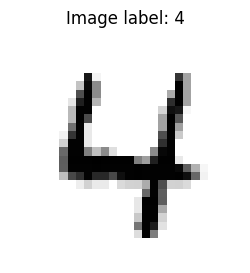

In [7]:
# Print an image
sample_index = 42

plot_mnist(digits_train, sample_index)
plt.show()

### Preprocessing: 
 * During this step, we will do some normalization on both the training and testing dataset.

In [8]:
# Extract and convert the pixel as numpy array with dtype='float32'
train = np.asarray(digits_train.iloc[:, 1:], dtype='float32')
test = np.asarray(digits_test, dtype='float32')

train_target = np.asarray(digits_train.loc[:, 'label'], dtype='int32')

In [9]:
# Scale the data
scaler = preprocessing.StandardScaler()
train_scale = scaler.fit_transform(train)
test_scale = scaler.transform(test)

## Implementation using Numpy

### The Logistic Regression

In this section, we will implement a logistic regression model trainable with Stochastic Gradient Descent (SGD) using `Numpy`. Here are the objectives:
* Implement a simple forward model with no hidden layer (equivalent to logisitic regression).
* Build a predict function which returns the most probable class given an input $x$.
* Build an accuracy function for a batch of inputs $X$ and the corresponding expected output $y_{true}$.
* Build a gradient function which computes the derivative of $-\log(softmax(Wx + b))$ with respect to $W$ for an $x$ and its corresponding expected output $y_{true}$.
* Build a train function which uses the gradient function out to update $\mathbf{W}$ and $b$.

**One-hot encoding for class label data**

First, let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes (similar to Keras `to_categorical` or sklearn `OneHotEncoder`).

In [10]:
def one_hot(n_classes, y):
    """Encode categorical integer as a one-hot numerical array.
    
    Parameters
    ----------
    n_classes: integer
        The number of class considered
    y: integer array
        The integers that represent a category
    
    Return
    ------
    An array containing the one-hot encoding of the categorical
    array.
    
    Examples
    --------
    >>>one_hot(n_classes=10, y=3)
    array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
    
    >>>one_hot(n_classes=10, y=[3, 0, 6])
    array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
           [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
    """
    return np.eye(n_classes)[y]

**The softmax function**

Now, let's implement the softmax vector function:

$$softmax(\mathbf{x}) = \frac{1}{\sum \exp(x_i)}\begin{pmatrix}\exp(x_1) & \exp(x_2) & \dots & \exp(x_n)\end{pmatrix}^\top.$$

In fact, we will substract $\max{x}$ to each $x_i$ for implementation and more robust and stable computation.

In [11]:
def softmax(X):
    """ Compute the softmax function of a vector.
    
    Parameters
    ----------
    X: array
        Input values
    
    Return
    ------
    An array containing the softmax values. For each row, the
    sum of the column should be one.
    
    Examples
    --------
    >>>softmax([10, 2, -3])
    array([9.99662391e-01, 3.35349373e-04, 2.25956630e-06])
    >>>softmax([[10, 2, -3],
                [-1, 5, -20]])
    array([[9.99662391e-01, 3.35349373e-04, 2.25956630e-06],
       [2.47262316e-03, 9.97527377e-01, 1.38536042e-11]])
    """
    X = np.atleast_2d(X)
    
    exp = np.exp(X - np.max(X, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=-1, keepdims=True)

In [12]:
# Test of the softmax function
print(f"Softmax of a single vector: {softmax([10, 2, -3])}.")

Softmax of a single vector: [[9.99662391e-01 3.35349373e-04 2.25956630e-06]].


In [13]:
# Check that the probabilities sum to one
print(f"Sum of a softmax vector: {np.sum(softmax([10, 2, -3]))}")

Sum of a softmax vector: 1.0


In [14]:
# Test of the softmax function of two vectors
print(f"Softmax of two vectors: {softmax([[10, 2, -3], [-1, 5, -20]])}.")

Softmax of two vectors: [[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]].


In [15]:
# Check that the probabilities sum to one
print(f"Sum of a softmax vector: {np.sum(softmax([[10, 2, -3], [-1, 5, -20]]), axis=1)}")

Sum of a softmax vector: [1. 1.]


**The negative log-likelihood**

Then, we implement a function that given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred` returns the negative log-likelihood.

In [16]:
def neg_log_likelihood(Y_true, Y_pred):
    """Compute the negative log-likelihood of a sample.
    
    Parameters
    ----------
    Y_true: array
        One-hot encoded class
    Y_pred: array
        Predicted probabilities
    
    Return
    ------
    The average negative log-likelihood of the sample. The closest we are
    to 0, the better are the predictions.
    
    Examples
    --------
    >>>neg_log_likelihood([1, 0, 0], [0.99, 0, 0.01])
    array([0.01005034])
    >>>neg_log_likelihood([1, 0, 0], [0.01, 0.98, 0.01])
    array([4.60517019])
    >>>Y_true = np.array([[0, 1, 0],
                          [1, 0, 0],
                          [0, 0, 1]])
    >>>Y_pred = np.array([[0,   1,    0],
                          [.99, 0.01, 0],
                          [0,   0,    1]])
    >>>neg_log_likelihood(Y_true, Y_pred)
    0.00335011195116715
    """
    Y_true = np.atleast_2d(Y_true)
    Y_pred = np.atleast_2d(Y_pred)
    
    loglike = np.sum(np.log(1e-8 + Y_pred) * Y_true, axis=1)
    return -np.mean(loglike)

In [17]:
# Make sure that it works for a simple sample at a time
print(f"Negative log-likelihood : {neg_log_likelihood([1, 0, 0], [.99, 0.01, 0])}.")

Negative log-likelihood : 0.01005032575249135.


In [18]:
# Check that the negative log-likelihood of a very confident yet bad
# prediction is a much higher positive number
print(f"Negative log-likelihood : {neg_log_likelihood([1, 0, 0], [0.01, 0.01, .98])}.")

Negative log-likelihood : 4.605169185988592.


In [19]:
# Check that the average negative log-likelihood of the following three
# almost perfect predictions is close to 0
Y_true = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]])
Y_pred = np.array([[0, 1, 0], [.99, 0.01, 0], [0, 0, 1]])

print(f"Negative log-likelihood : {neg_log_likelihood(Y_true, Y_pred)}.")

Negative log-likelihood : 0.0033501019174971905.


**Logistic regression with SGD**

Let us now study the following linear model trainable by SGD, **one sample at a time**.

In [20]:
class LogisticRegression():
    """Define a class for the Logistic Regression with SGD optimization
    
    Parameters
    ----------
    input_size: integer
        Input size of the model (number of features)
    output_size: integer
        Output size of the model (number of classes)
        
    Arguments
    ---------
    W: array
        Array of weights
    b: vector
        Vector of bias
    output_size: integer
        Output size of the model (number of classes)
    """
    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   low=-0.1, high=0.1)
        self.b = np.random.uniform(size=output_size,
                                   low=-0.1, high=0.1)
        self.output_size = output_size
        
    def forward(self, X):
        """Compute the posterior probabilities
        
        Parameter
        ---------
        X: array, shape=(n_obs, n_features)
            Input array
            
        Return
        ------
        An array of shape `(n_obs, n_class)` of probabilities of each class.
        """
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        """Give the most probable class of the observations
        
        Parameter
        ---------
        X: array, shape=(n_obs, n_features)
            Input array
        
        Return
        ------
        A vector of length `n_obs` that give the predicted class for
        each observation.
        """
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
        
    def grad_loss(self, X, y_true):
        """Backpropagation of the gradients
        https://m2dsupsdlclass.github.io/lectures-labs/slides/02_backprop/index.html#40
        
        Parameters
        ----------
        X: array
            Observations
        y_true: integer
            True class of the observations
            
        Return
        ------
        Dictionnary containing the gradients for the weighs and the bias.
        """
        y_pred = self.forward(X)
        dnll_ouput = y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(X, dnll_ouput)
        grad_b = dnll_ouput
        return {'W': grad_W, 'b': grad_b}
    
    def train(self, X, y, learning_rate=0.01):
        """Perform traditional SGD update without momentum.
        Update self.W and self.b
        
        Parameters
        ----------
        X: array
            Observations
        y: vector
            True classes
        learning_rate: double, default=0.01
            Learning rate
        """
        grads = self.grad_loss(X, y)
        self.W = self.W - learning_rate * grads['W']
        self.b = self.b - learning_rate * grads['b']
    
    def loss(self, X, y):
        """Compute the negative log-likelihood of the data.
        
        Parameters
        ----------
        X: array
            Observations
        y: vector
            True classes
            
        Return
        ------
        The average negative log-likelihood of the prediction of the observations.
        """
        return neg_log_likelihood(one_hot(self.output_size, y), self.forward(X))
    
    def accuracy(self, X, y):
        """Compute the prediction accuracy of the data.
        
        Parameters
        ----------
        X: array
            Observations
        y: vector
            True classes
            
        Return
        ------
        The accuracy of the predictions
        """
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [21]:
# Split the train set into train and validation set.
X_train, X_val, y_train, y_val = train_test_split(
    train_scale, train_target, test_size=0.15, random_state=42)

In [22]:
# Build a logistic model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

print(f"""Evaluation of the untrained model (recall that the weight and the bias are initialized as random):
    * train loss: {lr.loss(X_train, y_train)}
    * train accuracy: {lr.accuracy(X_train, y_train)}
    * test accuracy: {lr.accuracy(X_val, y_val)}
    """)

Evaluation of the untrained model (recall that the weight and the bias are initialized as random):
    * train loss: 2.7780068216979923
    * train accuracy: 0.11442577030812325
    * test accuracy: 0.11142857142857143
    


Of course, without training the results are very poor! With random initialization, we perform almost the same than just random guessing which have a test accuracy of $0.1$.

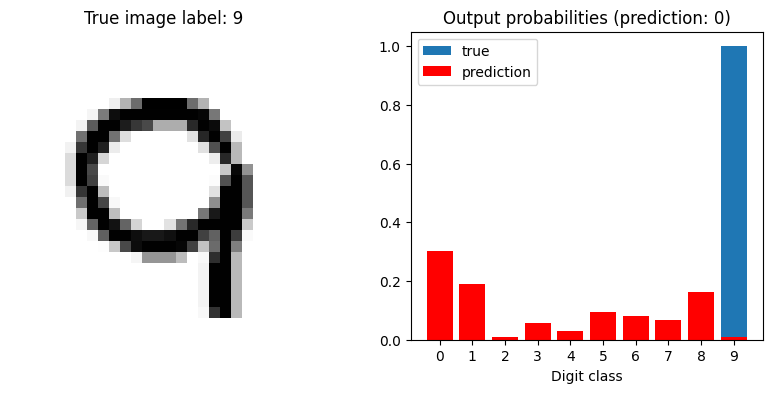

In [23]:
plot_prediction(X_val, y_val, lr, sample_idx=42)

Now, we will train the network for only one epoch.

In [24]:
learning_rate = 0.01
for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 10000 == 0:
        print(f"Update #{i}: train loss: {lr.loss(X_train, y_train)}, train accuracy: {lr.accuracy(X_train, y_train)}, test accuracy: {lr.accuracy(X_val, y_val)}")

Update #0: train loss: 2.7392757292283316, train accuracy: 0.12652661064425771, test accuracy: 0.12365079365079365
Update #10000: train loss: 0.677546170221836, train accuracy: 0.8711484593837535, test accuracy: 0.8639682539682539
Update #20000: train loss: 0.5878021217455002, train accuracy: 0.8938095238095238, test accuracy: 0.8790476190476191
Update #30000: train loss: 0.6311159460106528, train accuracy: 0.8910924369747899, test accuracy: 0.8752380952380953


After one epoch, we can see that the test accuracy is a bit less than $0.9$ (which is quite nice). 
Now, we will evaluate the model on the same image as before to see if the result changes.

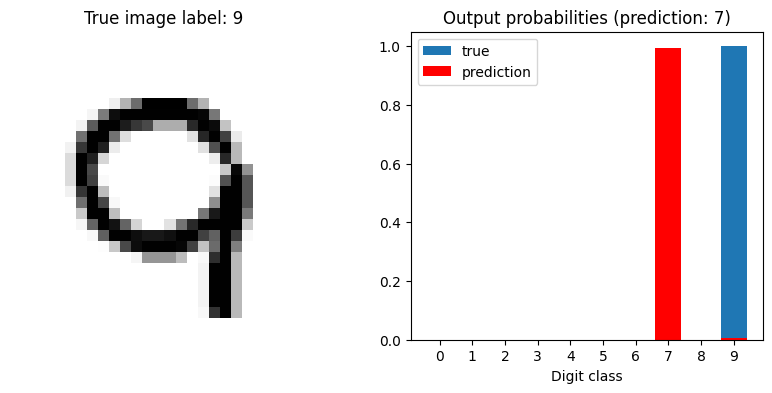

In [25]:
plot_prediction(X_val, y_val, lr, sample_idx=42)

Even if it's wrong, the model is now very confident for the prediction of the new image, which was not the case before the first epoch (usually the probability to belong to a particular class is below $0.4$). 

### The Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

**The sigmoid function**

The sigmoid function is defined by:
$$S(x) = \frac{1}{1 + \exp(-x)} = \frac{\exp(x)}{\exp(x) + 1}$$

The derivative of the sigmoid function is defined by:
$$\frac{dS(x)}{dx} = S(x)\left(1 - S(x)\right)$$

In [26]:
# Definition of the sigmoid function.
def sigmoid(X):
    """Compute the sigmoid function.
    
    Parameter
    ---------
    X: array-like
        Input array
        
    Return
    ------
    Sigmoid function on the input array.
    
    Examples
    --------
    >>>sigmoid(np.array([5, 2, 0]))
    array([0.99330715, 0.88079708, 0.5])
    >>>sigmoid(np.array([[5, 2, 0], [-2, 3, 0]]))
    array([[0.99330715, 0.88079708, 0.5],
           [0.11920292, 0.95257413, 0.5]])
           
    Notes
    -----
    X < -709 is to prevent exp overflow.
    """
    X[X < -709] = -709
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    """Compute the element-wide derivative of the sigmoid function.
    
    Parameter
    ---------
    X: array-like
        Input array
    
    Return
    ------
    Derivative of the sigmoid function on the input array.
    
    Examples
    --------
    >>>dsigmoid(np.array([5, 2, 0]))
    array([0.00664806, 0.10499359, 0.25])
    >>>dsigmoid(np.array([[5, 2, 0], [-2, 3, 0]]))
    array([[0.00664806, 0.10499359, 0.25],
           [0.10499359, 0.04517666, 0.25]])
    """
    S = sigmoid(X)
    return S * (1 - S)

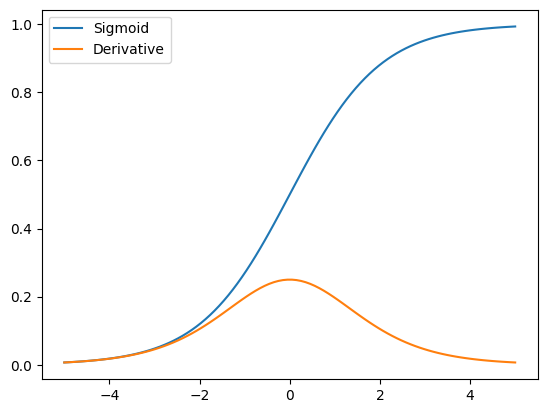

In [27]:
# Plot of the functions
X = np.linspace(-5, 5, 100)
plt.plot(X, sigmoid(X), label='Sigmoid')
plt.plot(X, dsigmoid(X), label='Derivative')
plt.legend(loc='best')
plt.show()

**The tanh function**

The tanh function is defined by:
$$T(x) = \frac{\exp(2x) - 1}{\exp(2x) + 1}$$

The derivative of the tanh function is defined by:
$$\frac{dT(x)}{dx} = 1 - T(x)^2$$

In [28]:
# Definition of the tanh function.
def tanh(X):
    """Compute the tanh function.
    
    Parameter
    ---------
    X: array-like
        Input array
        
    Return
    ------
    Tanh function on the input array.
    
    Examples
    --------
    >>>tanh(np.array([5, 2, 0]))
    array([0.9999092 , 0.96402758, 0.])
    >>>tanh(np.array([[5, 2, 0], [-2, 3, 0]]))
    array([[ 0.9999092 ,  0.96402758,  0.],
           [-0.96402758,  0.99505475,  0.]])
    
    Notes
    -----
    X > 354 is to prevent exp overflow.
    """
    X[X > 354] = 354
    exp = np.exp(2*X)
    return (exp - 1) / (exp + 1)

def dtanh(X):
    """Compute the element-wide derivative of the tanh function.
    
    Parameter
    ---------
    X: array-like
        Input array
    
    Return
    ------
    Derivative of the tanh function on the input array.
    
    Examples
    --------
    >>>dtanh(np.array([5, 2, 0]))
    array([1.81583231e-04, 7.06508249e-02, 1.00000000e+00])
    >>>dtanh(np.array([[5, 2, 0], [-2, 3, 0]]))
    array([[1.81583231e-04, 7.06508249e-02, 1.00000000e+00],
           [7.06508249e-02, 9.86603717e-03, 1.00000000e+00]])
    """
    S = tanh(X)
    return 1 - np.power(S, 2)

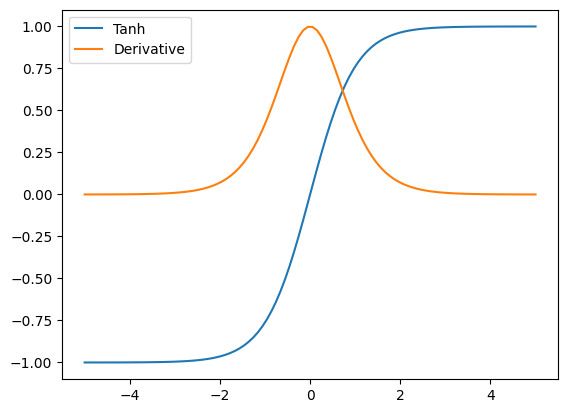

In [29]:
# Plot of the functions
X = np.linspace(-5, 5, 100)
plt.plot(X, tanh(X), label='Tanh')
plt.plot(X, dtanh(X), label='Derivative')
plt.legend(loc='best')
plt.show()

**The relu function**

The relu function is defined by:
$$R(x) = \max(0, x)$$

The derivative of the relu function is defined by:
$$\frac{dR(x)}{dx} = \mathbb{1}(x > 0)$$

In [30]:
# Definition of the relu function.
def relu(X):
    """Compute the relu function.
    
    Parameter
    ---------
    X: array-like
        Input array
        
    Return
    ------
    Relu function on the input array.
    
    Examples
    --------
    >>>relu(np.array([5, -2, 0]))
    array([5, 0, 0])
    >>>relu(np.array([[5, 2, 0], [-2, 3, 0]]))
    array([[5, 2, 0],
           [0, 3, 0]])
    """
    return np.maximum(0, X).astype(np.float64)

def drelu(X):
    """Compute the element-wide derivative of the relu function.
    
    Parameter
    ---------
    X: array-like
        Input array
    
    Return
    ------
    Derivative of the relu function on the input array.
    
    Examples
    --------
    >>>drelu(np.array([5, -2, 0]))
    array([1., 0., 0.])
    >>>drelu(np.array([[5, 2, 0], [-2, 3, 0]]))
    array([[1., 1., 0.],
           [0., 1., 0.]])
    """
    return np.array(X > 0).astype(np.float64)

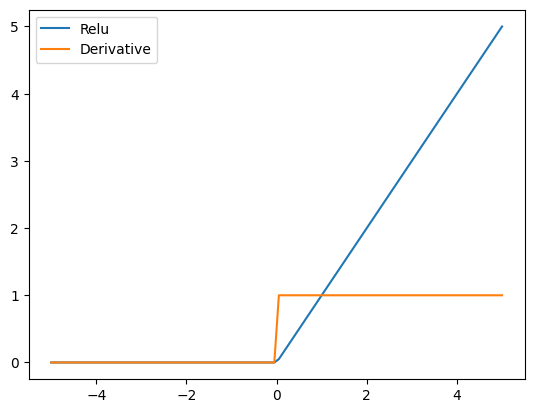

In [31]:
# Plot of the functions
X = np.linspace(-5, 5, 100)
plt.plot(X, relu(X), label='Relu')
plt.plot(X, drelu(X), label='Derivative')
plt.legend(loc='best')
plt.show()

**The feedforward neural network with one hidden layer**

In [32]:
EPSILON = 1e-8

class NeuralNet():
    """Define a class for the MultiLayer Perceptron with 
    one hidden layer with a sigmoid activation function.
    
    Parameters
    ----------
    input_size: integer
        Input size of the model (number of features)
    hidden_size: integer
        Size of the hidden layer (hyperparameter)
    output_size: integer
        Output size of the model (number of classes)
    activation_function: 'sigmoid', 'tanh' or 'relu', default='sigmoid'
        Activation function for the hidden layer.
    Arguments
    ---------
    W_h: array
        Weight array of the hidden layer
    W_o: array
        Weight array of the output layer
    b_h: vector
        Bias vecor of the hidden layer
    b_o: vector
        Bias vector of the output layer
    output_size: integer
        Output size of the model (number of classes)
    """
    def __init__(self, input_size, hidden_size, output_size, activation_function='sigmoid'):
        self.W_h = np.random.uniform(size=(input_size, hidden_size),
                                     low=-0.1, high=0.1)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(size=(hidden_size, output_size),
                                     low=-0.1, high=0.1)
        self.b_o = np.zeros(output_size)
        self.output_size = output_size
        self.activation_function = activation_function
        
    def forward(self, X):
        """Compute the posterior probabilities.
        
        Parameter
        ---------
        X: array, shape=(n_obs, n_features)
            Input array
        
        Return
        ------
        An array of shape `(n_obs, n_class)` of probabilities of each class.
        """
        if self.activation_function == 'tanh':
            h = tanh(np.dot(X, self.W_h) + self.b_h)
        elif self.activation_function == 'relu':
            h = relu(np.dot(X, self.W_h) + self.b_h)
        else:
            h = sigmoid(np.dot(X, self.W_h) + self.b_h)
        y = softmax(np.dot(h, self.W_o) + self.b_o)
        return y
    
    def forward_physical(self, X):
        """Compute the posterior probabilities with physical model errors."""
        # Error factor: standard normal distribution (mean=0, std=1)
        error_factor_W_h = np.random.normal(loc=0, scale=1, size=self.W_h.shape)
        error_factor_W_o = np.random.normal(loc=0, scale=1, size=self.W_o.shape)
        error_factor_b_h = np.random.normal(loc=0, scale=1, size=self.b_h.shape)
        error_factor_b_o = np.random.normal(loc=0, scale=1, size=self.b_o.shape)

        # Adjust weights with 30% systematic error
        W_h = self.W_h * (1 + 0.3 * error_factor_W_h)
        W_o = self.W_o * (1 + 0.3 * error_factor_W_o)
        b_h = self.b_h * (1 + 0.3 * error_factor_b_h)
        b_o = self.b_o * (1 + 0.3 * error_factor_b_o)

        z_h = np.dot(X, W_h) + b_h
        h = self._apply_activation(z_h)
        y = softmax(np.dot(h, W_o) + b_o)
        return y 
    
    def forward_keep_activations(self, X):
        """Compute the posterior probabilities.
        
        Parameter
        ---------
        X: array, shape=(n_obs, n_features)
            Input array
            
        Return
        ------
        An array of shape `(n_obs, n_class)` of probabilities of each class,
        and the hidden activations and pre-activitations arrays.
        """
        z_h = np.dot(X, self.W_h) + self.b_h
        if self.activation_function == 'tanh':
            h = tanh(z_h)
        elif self.activation_function == 'relu':
            h = relu(z_h)
        else:
            h = sigmoid(z_h)
        y = softmax(np.dot(h, self.W_o) + self.b_o)
        return y, h, z_h

    def forward_keep_activations_physical(self, X):
        """Compute the posterior probabilities with physical model errors, keeping activations."""
        # Error factor: standard normal distribution (mean=0, std=1)
        error_factor_W_h = np.random.normal(loc=0, scale=1, size=self.W_h.shape)
        error_factor_W_o = np.random.normal(loc=0, scale=1, size=self.W_o.shape)
        error_factor_b_h = np.random.normal(loc=0, scale=1, size=self.b_h.shape)
        error_factor_b_o = np.random.normal(loc=0, scale=1, size=self.b_o.shape)

        # Adjust weights with 30% systematic error
        W_h = self.W_h * (1 + 0.3 * error_factor_W_h)
        W_o = self.W_o * (1 + 0.3 * error_factor_W_o)
        b_h = self.b_h * (1 + 0.3 * error_factor_b_h)
        b_o = self.b_o * (1 + 0.3 * error_factor_b_o)

        z_h = np.dot(X, W_h) + b_h
        h = self._apply_activation(z_h)
        y = softmax(np.dot(h, W_o) + b_o)
        return y, h, z_h 
       
    def grad_loss(self, X, y_true):
        """Backpropagation of the gradients
        https://m2dsupsdlclass.github.io/lectures-labs/slides/02_backprop/index.html#40
        
        Parameters
        ----------
        X: array
            Observations
        y_true: integer
            True class of the observations
            
        Return
        ------
        Dictionary containing the gradients for the weights and the bias.
        """
        y_pred, h, z_h = self.forward_keep_activations_physical(X)
        grad_z_o = y_pred - one_hot(self.output_size, y_true)
        
        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        
        grad_h = np.dot(grad_z_o, np.transpose(self.W_o))
        if self.activation_function == 'tanh':
            grad_z_h = grad_h * dtanh(z_h)
        elif self.activation_function == 'relu':
            grad_z_h = grad_h * drelu(z_h)
        else:
            grad_z_h = grad_h * dsigmoid(z_h)
        
        grad_W_h = np.outer(X, grad_z_h)
        grad_b_h = grad_z_h
        
        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}
    
    def train(self, X, y, learning_rate):
        """Perform traditional SGD update without momentum.
        Update self.W_h, self.W_o, self.b_h and self.b_o.
        
        Parameters
        ----------
        X: array
            Observations
        y: vector
            True classes
        learning_rate: double, default=0.01
            Learning rate
        """
        grads = self.grad_loss(X, y)
        self.W_h = self.W_h - learning_rate * grads['W_h']
        self.b_h = self.b_h - learning_rate * grads['b_h']
        
        self.W_o = self.W_o - learning_rate * grads['W_o']
        self.b_o = self.b_o - learning_rate * grads['b_o']
    
    def predict(self, X):
        """Give the most probable class of the observations.
        
        Parameter
        ---------
        X: array, shape=(n_obs, n_features)
            Input array
        
        Return
        ------
        A vector of length `n_obs` that give the predicted class for each observation.
        """
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def loss(self, X, y):
        """Compute the negative log-likelihood of the data.
        
        Parameters
        ----------
        X: array
            Observations
        y: vector
            True classes
            
        Return
        ------
        The average negative log-likelihood of the prediction of the observations.
        """
        return neg_log_likelihood(one_hot(self.output_size, y), self.forward(X))
    
    def accuracy(self, X, y):
        """Compute the prediction accuracy of the data.
        
        Parameters
        ----------
        X: array
            Observations
        y: vector
            True classes
        
        Return
        ------
        The accuracy of the predictions
        """
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)
    
    def _apply_activation(self, z):
        """Helper function to apply activation function."""
        if self.activation_function == 'tanh':
            return tanh(z)
        elif self.activation_function == 'relu':
            return relu(z)
        else:
            return sigmoid(z)

    def _apply_activation_derivative(self, z):
        """Helper function to apply derivative of activation function."""
        if self.activation_function == 'tanh':
            return dtanh(z)
        elif self.activation_function == 'relu':
            return drelu(z)
        else:
            return dsigmoid(z)

In [33]:
# Build a NeuralNet model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

print(f"""Evaluation of the untrained model (recall that the weights are initialized as random):
    * train loss: {model.loss(X_train, y_train)}
    * train accuracy: {model.accuracy(X_train, y_train)}
    * test accuracy: {model.accuracy(X_val, y_val)}
    """)

Evaluation of the untrained model (recall that the weights are initialized as random):
    * train loss: 2.3091066835564025
    * train accuracy: 0.11277310924369748
    * test accuracy: 0.10539682539682539
    


As for the Logistic Regression model, the NeuralNet model performs very poorly before the training (because the weights are initialized as random). 

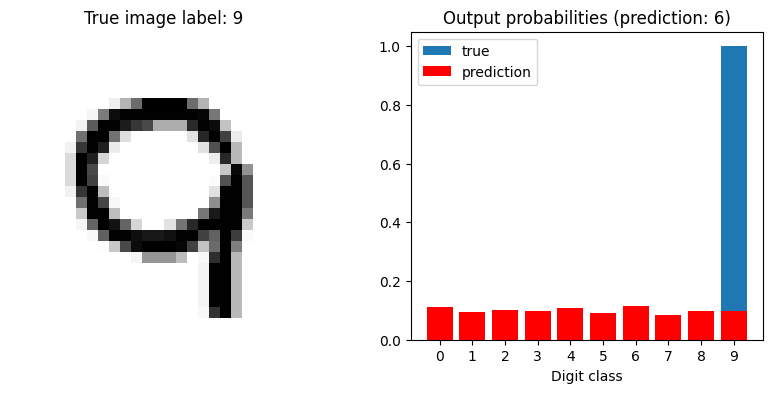

In [34]:
plot_prediction(X_val, y_val, model, sample_idx=42)

In [39]:
# Train the model for some epochs
EPOCHS = 50
learning_rate = 0.01

losses = [model.loss(X_train, y_train)]
accuracies = [model.accuracy(X_train, y_train)]
accuracies_val = [model.accuracy(X_val, y_val)]

for epoch in range(EPOCHS):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, learning_rate)
    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_val.append(model.accuracy(X_val, y_val))
    print(f"Epoch #{epoch+1}: train loss: {losses[-1]}, train accuracy: {accuracies[-1]}, test accuracy: {accuracies_val[-1]}")

Epoch #1: train loss: 0.3200785126163035, train accuracy: 0.9281792717086835, test accuracy: 0.8988888888888888
Epoch #2: train loss: 0.31153703694839024, train accuracy: 0.9296918767507003, test accuracy: 0.9014285714285715
Epoch #3: train loss: 0.3119841407304756, train accuracy: 0.9309803921568628, test accuracy: 0.9015873015873016
Epoch #4: train loss: 0.30807328024728853, train accuracy: 0.9325210084033614, test accuracy: 0.9012698412698412
Epoch #5: train loss: 0.3091614767955129, train accuracy: 0.9315406162464986, test accuracy: 0.902063492063492
Epoch #6: train loss: 0.3137025826354531, train accuracy: 0.9311204481792718, test accuracy: 0.9011111111111111
Epoch #7: train loss: 0.3170974255051763, train accuracy: 0.9313165266106442, test accuracy: 0.9041269841269841
Epoch #8: train loss: 0.32790641246989644, train accuracy: 0.9300560224089636, test accuracy: 0.9011111111111111
Epoch #9: train loss: 0.3215671671923243, train accuracy: 0.9323249299719888, test accuracy: 0.9023809

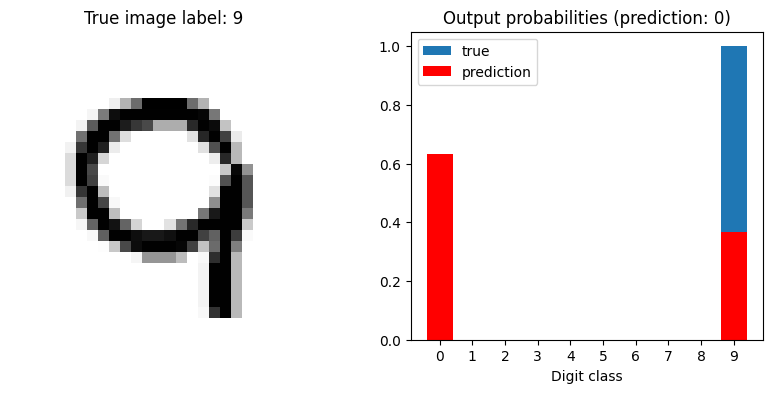

In [52]:
plot_prediction(X_val, y_val, model, sample_idx=42)

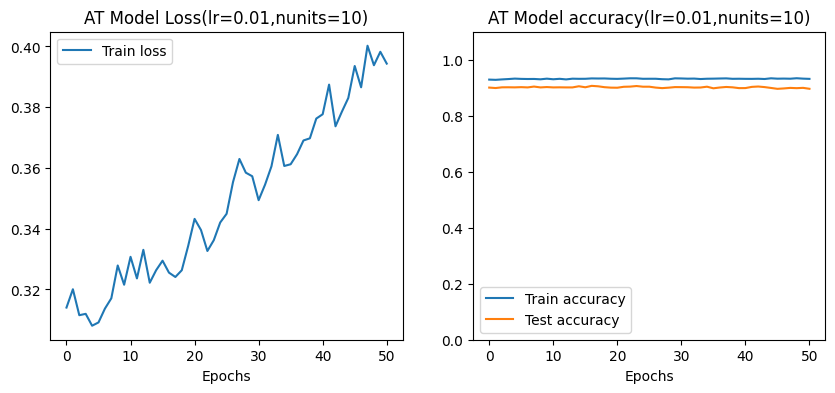

In [53]:
# Plot losses and accuracies.
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

ax0.plot(losses, label='Train loss')
ax0.set_title('AT Model Loss(lr=0.01,nunits=10)')
ax0.set_xlabel('Epochs')
ax0.legend()

ax1.plot(accuracies, label='Train accuracy')
ax1.plot(accuracies_val, label='Test accuracy')
ax1.set_title('AT Model accuracy(lr=0.01,nunits=10)')
ax1.set_ylim(0, 1.1)
ax1.set_xlabel('Epochs')
ax1.legend(loc='best')

plt.show()

In [ ]:
# The loss is the negative log-likelihood for each picture.
val_losses = -np.sum(np.log(1e-8 + model.forward(X_val)) * one_hot(10, y_val), axis=1)

# We, then, sort them by ascending loss.
rank_loss = val_losses.argsort()

# Plot the top 5 worst predictions
for idx in rank_loss[-5:]:
    plot_prediction(X_val, y_val, model, sample_idx=idx)